**Rank Minimization with Smoothness Constraints for Blind Deconvolution**
Anh-Huy Phan



We consider a convolutive mixing model

\begin{align}
    \bf y = \bf w * \bf x
\end{align}


where
- $\bf x$ is the unknown source signal,
- $\bf w$ is the convolutive kernel
- and ``*'' denotes the convolution


The blind deconvolution problem finds the unknown source, $\bf x$, from the observed signal, $\bf y$.

We will solve the problem as rank-minimization plus smoothness constraints




In [ ]:
!pip install pyunlocbox



In [ ]:
# Import libraries for array operations and image processing
import numpy as np
import scipy.io
import scipy.misc
import scipy.fftpack
import matplotlib.pyplot as plt
import imageio
from PIL import Image
import cvxpy as cp
from scipy import signal

from pyunlocbox import functions

<ipython-input-240-02ee178210ea>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png")


Text(0.5, 1.0, 'kernel')

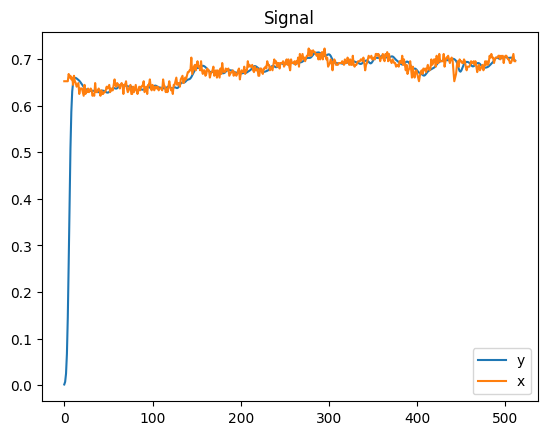

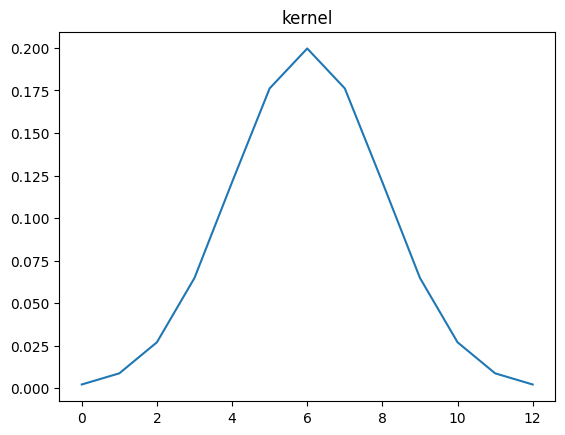

In [ ]:
# Generate data
# load the Lena image from a URL using imageio
im = imageio.imread("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png")
# resize the image to 512 x 512
im = Image.fromarray(im).resize((512,512))
im = im.convert("L")
im = np.array(im)/256 # Convert to double

# Get the signal x as one column of the image im
x = im[:,50]
x0 = x

# Gaussian kernel
sigma = 2
cutoff = np.ceil(3*sigma)
# h = fspecial('gaussian',[1,2*cutoff+1],sigma); % 1D filter
h = signal.windows.gaussian(2*cutoff+1,sigma)
h = h / np.sum(h) # Normalize the filter

# general signal y
y = scipy.signal.lfilter(h, 1, x) # Convolve the signal with the filter

# by default sum(h) == 1
plt.figure()
plt.plot(y)
plt.plot(x)
plt.legend({'y', 'x'})
plt.title('Signal')

plt.figure()
plt.plot(h)
plt.title('kernel')

In [ ]:
def liftingoper(B, szX, mode):
    # B: subspace of the kernels
    # y = B*h1 * s1 + Bh2 * x2
    # Phan AnhHuy
    # if mode = 'same'  length(y) = length(s)
    signal_size, kernelrank = szX[0], szX[1]
    szB = B.shape

    expandlenght = signal_size-1-szB[0]+1

    ALift = []
    for k in range(kernelrank): # number of columns of the matrix B
      #     elem = toeplitz([B(:,k);sparse(expandlenght,1)],[B(1,k) sparse(1,signal_size-1)]);
      Bx = np.concatenate([B[:,k], np.zeros(expandlenght)])
      hx = np.zeros(signal_size)
      hx[0] = B[0,k]
      elem = scipy.linalg.toeplitz(Bx,hx)

      ALift.append(elem)

    ALift = np.concatenate(ALift, axis=1)

    Amap = lambda X: np.dot(ALift, X.flatten()) # A* X(:)
    ATmap = lambda b: np.reshape(np.dot(ALift.T, b), szX) # A'*b
    return Amap, ATmap, ALift


2.2732927345233e-15


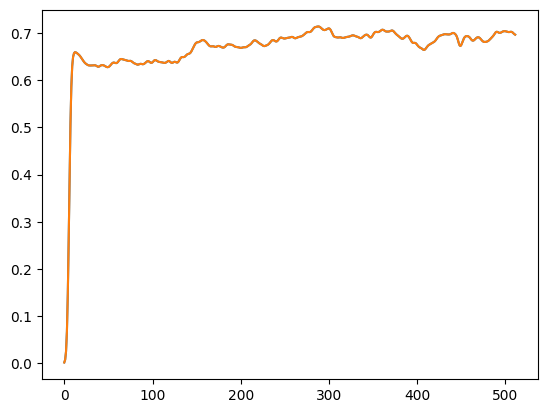

In [ ]:
# TEST LIFTING operator
# conv(x,h) = Alift*vec(x*h')
szX = [len(x), len(h)]

B = np.eye(len(h))
mode = 'same'
[Amap,ATmap,ALift] = liftingoper(B,szX,mode) # Define your own liftingoper function

Xh = x.reshape(-1,1) @ h.reshape(-1,1).T
yh = ALift @ Xh.T.reshape(-1)
print(np.linalg.norm(y - yh))

plt.figure()
plt.plot(y)
plt.plot(yh)

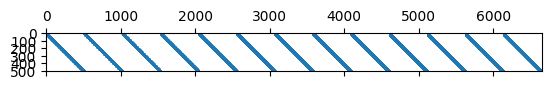

In [ ]:
plt.figure()
plt.spy(ALift,markersize=1)

In [ ]:

def rank1component_extraction(Z):
    uz, sz, vz = np.linalg.svd(Z, full_matrices=False)
    xh = uz[:, 0]
    hh = vz[0, :] * sz[0]
    sumW = np.sum(hh)
    hh = hh / sumW
    xh = xh * sumW
    ix = np.argmax(np.abs(hh))
    xh = xh * np.sign(hh[ix])
    hh = hh * np.sign(hh[ix])
    return xh, hh



Method 1: rank minimization with linear constraint

\begin{align}
min \quad & \|X \|_*    \\
\text{s.t.} \quad &  A \, vec(X) == y
\end{align}


In [ ]:
# CVX optimization
Z = cp.Variable(szX)
objective = cp.Minimize(cp.norm(Z, 'nuc'))
constraints = [ALift @ cp.reshape(Z,(szX[0]*szX[1],1)) == y.reshape(-1,1)]
prob = cp.Problem(objective, constraints)
prob.solve()

4.314440228424019

[None, None]

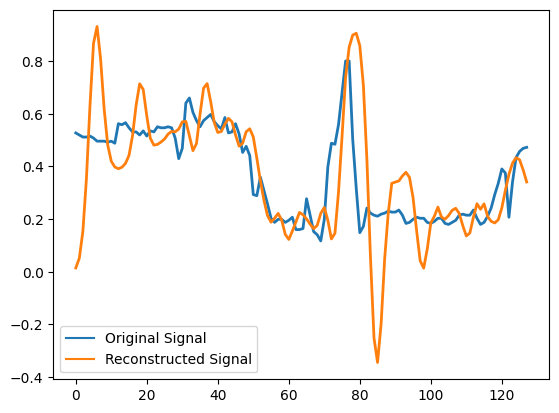

In [ ]:
# Extract source signal and convolutional kernel from Z
[xh,hh] = rank1component_extraction(Z.value) # Define your own rank1component_extraction function

plt.figure(1)
plt.clf()

l1 = plt.plot(x)
l2 = plt.plot(xh)
plt.legend(['Original Signal', 'Reconstructed Signal'])
plt.setp([l1, l2], linewidth=2)


**Rank minimization + smoothness**.

\begin{align}
min \quad & \|X \|_* + \gamma \|X \|_{TV}   \\
\text{s.t.} \quad &  A \, vec(X) == y
\end{align}

In [ ]:
# Rank minimization + smoothness
gamma = 0.1
Zs = cp.Variable(szX)
g = 0
for k in range(len(h)):
  g = g + cp.norm(Zs[1:,k]-Zs[:-1,k],1)

objective = cp.Minimize(cp.norm(Zs, 'nuc') + gamma*g)
constraints = [ALift @ cp.reshape(Zs,(szX[0]*szX[1],1)) == y.reshape(-1,1)]
prob = cp.Problem(objective, constraints)
prob.solve()



1.7134691603205177

[None, None]

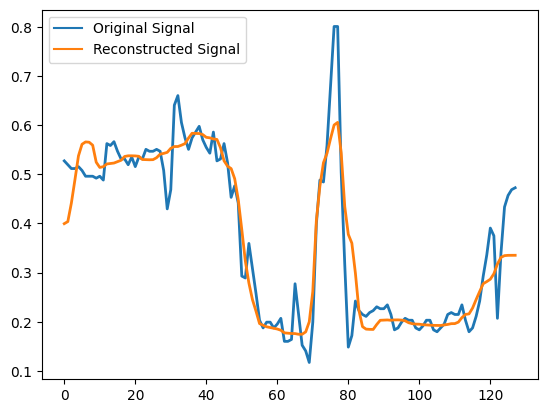

In [ ]:
[xhsm,hhsm] = rank1component_extraction(Zs.value)

plt.figure(2)
plt.clf()
l1 = plt.plot(x)
l2 = plt.plot(xhsm)
plt.legend(['Original Signal', 'Reconstructed Signal'])
plt.setp([l1, l2], linewidth=2)

ADMM algorithm for the rank-1 minimization + smoothness constraints

\begin{align}
min \quad & \|Z \|_* + \gamma \|X \|_{TV} + i_A(F) \\
\text{s.t.} \quad &  Z =  F \\
&       X = F
\end{align}
where $i_A(F)$ is indicator for set of $F$ such that $y = A vec(F)$

In [ ]:

# ADMM algorithm for
#  min  ||Z||* + gamma ||X||_TV + i_A(F)
# s,t  Z =  F
#      X = F
#
# iA(F) = indicator ( y = Alift*vec(F))
#
#
gamma = .01;
lambda_ = 5 #
T1 = np.zeros(szX)
T2 = np.zeros(szX)
#Fk = Z
yK = y
dualF = yK / szX[1]
dualF[:szX[1]] = yK[:szX[1]] / np.arange(1, szX[1]+1)

Fk = ATmap(dualF) # Define your own ATmap function
Fk = Fk.reshape(szX)

err = []



In [ ]:
for kiter in range(100):
  # update Z
  D1 = Fk + T1
  # cvx_begin
  # variable Zk(szX)
  # minimize (norm_nuc(Zk)+lambda/2*sum_square(Zk(:)-D1(:)));
  # cvx_end

  ud,sd,vd = np.linalg.svd(D1, full_matrices=False)
  sd = np.maximum(sd-1/lambda_,0)

  Zk = ud @ np.diag(sd) @ vd

  # Update X
  D2 = Fk + T2
  # X = argmin gamma ||X||TV+lambda/2 ||X - F-T2||F^2
  # cvx_begin
  # variable Xk(szX)
  # g = 0
  # for k = 1:szX(2)
  #     g = g + norm(Xk(2:end,k)-Xk(1:end-1,k),1)
  # end
  # minimize (gamma*g + lambda/2*sum_square(Xk(:)-D2(:)));
  # cvx_end

  # sol = argmin_{z} 0.5*||x - z||_2^2 + gamma * ||x||_TV
  param = {'tol': 1e-7, 'verbose': 0}
  Xk = np.zeros(szX)
  for k in range(szX[1]):
    # solk, info = prox_tv1d(D2[:,k], gamma/lambda_, param) # Define your own prox_tv1d function
    f = functions.norm_tv(tol=10e-7, dim=1,verbosity = 0)
    solk = f.prox(D2[:,k],gamma/lambda_)
    Xk[:,k] = solk

  # Update F
  K2 = Xk-T2
  K1 = Zk-T1
  K = (K1+K2)/2
  # F = argmin ||F - K||F^2  s.t.   y = Alift*vec(F)
  # cvx_begin
  # variable Fk(szX)
  # dual variable dF
  # minimize sum_square(Fk(:)-K(:))
  # subject to
  # dF: ALift * reshape(Fk,[],1) == y
  # cvx_end

  yK = y - ALift @ K.T.reshape(-1)
  dualF = yK / szX[1]
  dualF[:szX[1]] = yK[:szX[1]] / np.arange(1, szX[1]+1)

  Fk = ALift.T@dualF + K.T.reshape(-1)

  #Fk = ATmap(dualF) + K
  Fk = Fk.reshape([szX[1], szX[0]]).T


  # Update dual

  T1 = T1 + Fk - Zk
  T2 = T2 + Fk - Xk

  errZF = np.linalg.norm(Zk-Fk,'fro')
  errXF = np.linalg.norm(Xk-Fk,'fro')
  errXZ = np.linalg.norm(Xk-Zk,'fro')

  print(f'{kiter}  |  d(Z,F)= {errZF}  | d(X,F)= {errXF}  |  d(X,Z) = {errXZ}')

  err.append([errZF,errXF,errXZ])

  if np.sum([errZF,errXF,errXZ])/3 < 1e-4:
    break


0  |  d(Z,F)= 0.38178298838280267  | d(X,F)= 0.29549462579076907  |  d(X,Z) = 0.35941725909111655
1  |  d(Z,F)= 0.19136004379883545  | d(X,F)= 0.25114995469094037  |  d(X,Z) = 0.21351289909111862
2  |  d(Z,F)= 0.0735616895395214  | d(X,F)= 0.05897545560901151  |  d(X,Z) = 0.1187504261356113
3  |  d(Z,F)= 0.06188999027007049  | d(X,F)= 0.053966672571311644  |  d(X,Z) = 0.10927412336990407
4  |  d(Z,F)= 0.04156851480823921  | d(X,F)= 0.03308566223790387  |  d(X,Z) = 0.06959430065917292
5  |  d(Z,F)= 0.02821836043118687  | d(X,F)= 0.01909817657171201  |  d(X,Z) = 0.041545359140506256
6  |  d(Z,F)= 0.023763718919143348  | d(X,F)= 0.01592988366700353  |  d(X,Z) = 0.034605392258311315
7  |  d(Z,F)= 0.020894498620227075  | d(X,F)= 0.013475572272063805  |  d(X,Z) = 0.02986736946880288
8  |  d(Z,F)= 0.018663628122185832  | d(X,F)= 0.011475252212456348  |  d(X,Z) = 0.025790283098199553
9  |  d(Z,F)= 0.01713132110892036  | d(X,F)= 0.010366079351581313  |  d(X,Z) = 0.023312599436959736
10  |  d(Z,

[None, None]

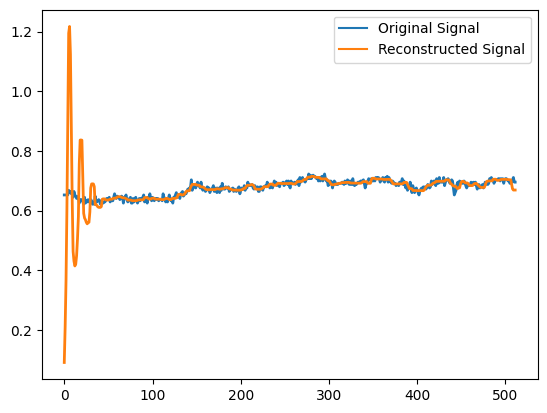

In [ ]:
# Extract source signal and convolutional kernel from Z
[xhadmm,hhadmm] = rank1component_extraction(Fk) # Define your own rank1component_extraction function

plt.figure(1)
plt.clf()

l1 = plt.plot(x)
l2 = plt.plot(xhadmm)
plt.legend(['Original Signal', 'Reconstructed Signal'])
plt.setp([l1, l2], linewidth=2)

[None, None]

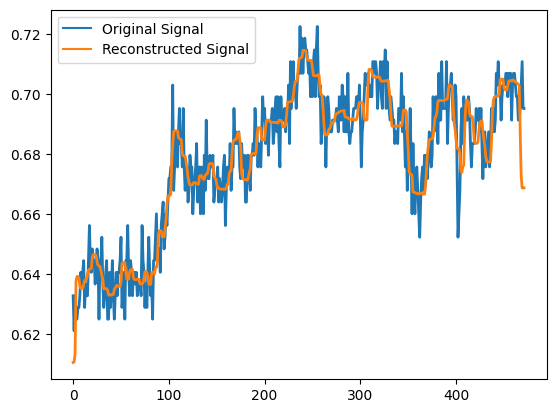

In [ ]:

plt.figure(2)
plt.clf()

l1 = plt.plot(x[40:])
l2 = plt.plot(xhadmm[40:])
plt.legend(['Original Signal', 'Reconstructed Signal'])
plt.setp([l1, l2], linewidth=2)